# train_dataset "context" 분포
- 아래 EDA는 Train_dataset의 context 열을 roberta-large 모델 토크나이저를 Reader에서 쓴다는 가정하에 분석한 것입니다.
- Reader의 성능을 올리기 위해, context 열을 전처리할 아이디어를 찾습니다.

In [1]:
from datasets import load_from_disk
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
dataset = load_from_disk("../../data/train_dataset/")
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [3]:
dataset['train'][0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

## Reader 모델에 사용할 roberta-large 토크나이저로 context 분석
- 토큰 길이 분석
- 토큰화 결과 직접 보기
- 토큰화 결과: UNK 분석

In [4]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

/shared/home/sw_innovation01/anaconda3/envs/odqa/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def tokenize_and_analyze(examples):
    # Tokenize the context column
    tokenized = tokenizer(examples['context'], padding=False, truncation=False, return_length=True)
    # Count the number of UNK tokens for each example
    unk_count = [tokens.count(tokenizer.unk_token_id) for tokens in tokenized['input_ids']]
    # Return the token lengths
    return {'tokens_length': tokenized['length'], 'unk_count': unk_count}

In [6]:
train_dataset = dataset['train'].map(tokenize_and_analyze, batched=True)
validation_dataset = dataset['validation'].map(tokenize_and_analyze, batched=True)

In [7]:
train_df = pd.DataFrame({
    'context': dataset['train']['context'],
    'tokens_length': train_dataset['tokens_length'],
    'unk_count': train_dataset['unk_count']
})
validation_df = pd.DataFrame({
    'context': dataset['validation']['context'],
    'tokens_length': validation_dataset['tokens_length'],
    'unk_count': validation_dataset['unk_count']
})

### 토큰 길이 분석

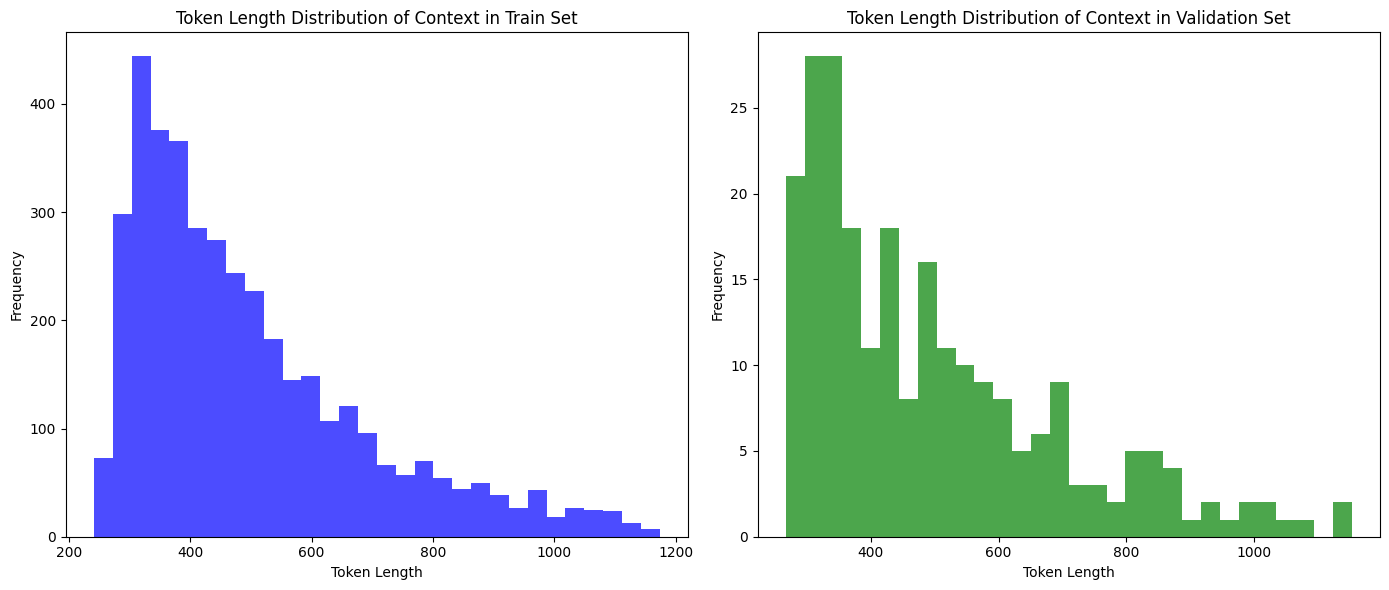

In [8]:
# Plot the distribution of token lengths for the train and validation sets side by side
plt.figure(figsize=(14, 6))

# Plot for the train set (left side)
plt.subplot(1, 2, 1)
plt.hist(train_df['tokens_length'], bins=30, alpha=0.7, color='blue')
plt.title('Token Length Distribution of Context in Train Set')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

# Plot for the validation set (right side)
plt.subplot(1, 2, 2)
plt.hist(validation_df['tokens_length'], bins=30, alpha=0.7, color='green')
plt.title('Token Length Distribution of Context in Validation Set')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [9]:
train_stats = train_df['tokens_length'].describe()
validation_stats = validation_df['tokens_length'].describe()

# 출력
print("Train set token length statistics:")
print(train_stats)
print("\nValidation set token length statistics:")
print(validation_stats)

Train set token length statistics:
count    3952.000000
mean      497.301619
std       193.801724
min       241.000000
25%       348.000000
50%       444.000000
75%       594.000000
max      1174.000000
Name: tokens_length, dtype: float64

Validation set token length statistics:
count     240.000000
mean      496.304167
std       197.632311
min       267.000000
25%       341.250000
50%       435.500000
75%       599.250000
max      1153.000000
Name: tokens_length, dtype: float64


### UNK 개수 분석

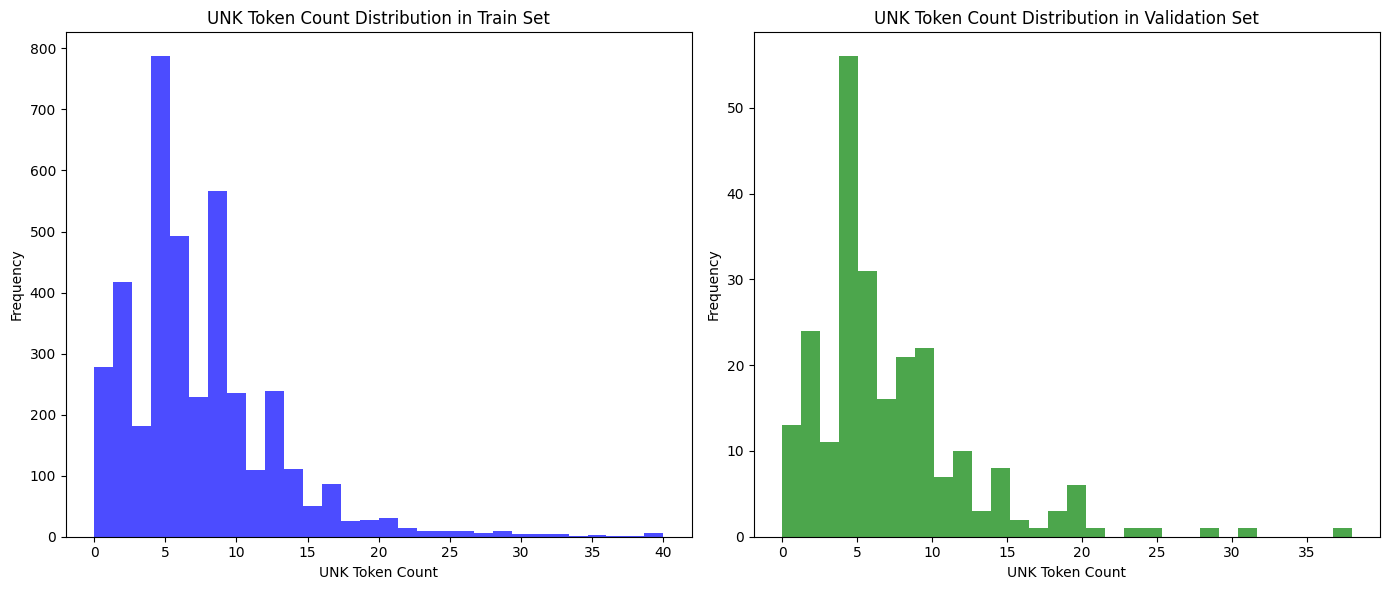

In [10]:
# Optionally, you can plot the distribution of UNK tokens in a similar way
plt.figure(figsize=(14, 6))

# Plot for the train set (left side)
plt.subplot(1, 2, 1)
plt.hist(train_df['unk_count'], bins=30, alpha=0.7, color='blue')
plt.title('UNK Token Count Distribution in Train Set')
plt.xlabel('UNK Token Count')
plt.ylabel('Frequency')

# Plot for the validation set (right side)
plt.subplot(1, 2, 2)
plt.hist(validation_df['unk_count'], bins=30, alpha=0.7, color='green')
plt.title('UNK Token Count Distribution in Validation Set')
plt.xlabel('UNK Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [11]:
# Now let's calculate and print some statistics for UNK tokens
train_unk_stats = train_df['unk_count'].describe()
validation_unk_stats = validation_df['unk_count'].describe()

train_stats = train_df['tokens_length'].describe()
validation_stats = validation_df['tokens_length'].describe()

# 출력
print("Train set unk statistics:")
print(train_unk_stats)
print("\nValidation set unk statistics:")
print(validation_unk_stats)

Train set unk statistics:
count    3952.000000
mean        7.155617
std         5.333886
min         0.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        40.000000
Name: unk_count, dtype: float64

Validation set unk statistics:
count    240.000000
mean       7.212500
std        5.492544
min        0.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       38.000000
Name: unk_count, dtype: float64


### UNK 원본단어 분석

In [12]:
def tokenize_and_find_unk(examples):
    tokenized = tokenizer(
        examples['context'], 
        padding=False, 
        truncation=False,
        return_offsets_mapping=True
    )
    
    batch_unk_original_words = []  # To store original words mapped to UNK

    for i in range(len(tokenized['input_ids'])):
        original_text = examples['context'][i]
        word_pieces = tokenizer.tokenize(original_text)
        offsets = tokenized['offset_mapping'][i]
        tokens = tokenized['input_ids'][i]
        
        unk_original_words = []
        # Iterate over tokens and offset mapping to find [UNK] tokens
        for j, token in enumerate(tokens):
            if token == tokenizer.unk_token_id:
                # Use the offset to extract the original word that corresponds to the [UNK] token
                start, end = offsets[j]
                unk_word = original_text[start:end] if start != end else "[UNKNOWN_WORD]"
                unk_original_words.append(unk_word)
        batch_unk_original_words.append(unk_original_words)
    
    # Return a list of original words that were tokenized as [UNK]
    return {'unk_original_words': batch_unk_original_words}


In [13]:
train_dataset_unk = dataset['train'].map(tokenize_and_find_unk, batched=True, remove_columns=dataset['train'].column_names)
validation_dataset_unk = dataset['validation'].map(tokenize_and_find_unk, batched=True, remove_columns=dataset['validation'].column_names)

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


In [14]:
train_unk_words = [word for sublist in train_dataset_unk['unk_original_words'] for word in sublist]
validation_unk_words = [word for sublist in validation_dataset_unk['unk_original_words'] for word in sublist]

In [15]:
print('len(train_unk_words):', len(train_unk_words))
print('len(validation_unk_words):', len(validation_unk_words))

len(train_unk_words): 28279
len(validation_unk_words): 1731


In [16]:
train_unk_counter = Counter(train_unk_words)
validation_unk_counter = Counter(validation_unk_words)

In [17]:
train_unk_df = pd.DataFrame(train_unk_counter.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
validation_unk_df = pd.DataFrame(validation_unk_counter.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

In [18]:
print("Top 10 words tokenized as [UNK] in train set:")
print(train_unk_df.head(10))

Top 10 words tokenized as [UNK] in train set:
     word  count
0       \  22808
84      –     56
24      李     30
733     臺     26
720     頭     25
485     臨     21
255     呂     20
140     皇     19
729     半     18
1488    番     18


In [19]:
print("\nTop 10 words tokenized as [UNK] in validation set:")
print(validation_unk_df.head(10))


Top 10 words tokenized as [UNK] in validation set:
    word  count
0      \   1370
1     촐라      7
206   µm      7
122    –      4
177    玄      4
255    戟      3
165    永      3
24     像      3
2    촐라의      3
20     。      3


In [20]:
print(repr(dataset['train'][0]['context'][:70]))
print(tokenizer.tokenize(dataset['train'][0]['context'][:70]))

'미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원'
['미국', '상의', '##원', '또는', '미국', '상원', '(', 'United', 'State', '##s', 'Se', '##n', '##ate', ')', '은', '양', '##원', '##제', '##인', '미국', '의회', '##의', '상원', '##이다', '.', '[UNK]', 'n', '[UNK]', 'n', '##미', '##국', '부통령', '##이', '상원']


In [21]:
print(tokenizer.convert_tokens_to_ids('\\'))
print(tokenizer.convert_tokens_to_ids('–'))
print(tokenizer.unk_token_id)

3
3
3


## \ \n 없애주고 다시 측정

In [22]:
def replace_newline_with_space(examples):
    # Replace all newline characters (\n) with a space in the context column
    examples['context'] = [context.replace('\\n', ' ') for context in examples['context']]
    return examples

In [23]:
preprocess_data = dataset['train'].map(replace_newline_with_space, batched=True)

In [24]:
preprocess_train_dataset_unk = preprocess_data.map(tokenize_and_find_unk, batched=True, remove_columns=preprocess_data.column_names)

In [25]:
preprocess_train_unk_words = [word for sublist in preprocess_train_dataset_unk['unk_original_words'] for word in sublist]

In [26]:
print('len(preprocess_train_unk_words):', len(preprocess_train_unk_words))

len(preprocess_train_unk_words): 5471


In [27]:
preprocess_train_unk_counter = Counter(preprocess_train_unk_words)
preprocess_train_unk_df = pd.DataFrame(preprocess_train_unk_counter.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
print("Top 10 words tokenized as [UNK] in preprocess train set:")
print(preprocess_train_unk_df.head(10))

Top 10 words tokenized as [UNK] in preprocess train set:
     word  count
82      –     56
23      李     30
727     臺     26
714     頭     25
480     臨     21
253     呂     20
138     皇     19
1478    番     18
723     半     18
434     里     16


## –가 어떤식인지 보겠습니다..
–를 찾자..

In [28]:
# 전처리 데이터셋에서 토큰화했을 때, unk 있는 데이터셋을 have_unk_dataset으로 반환
def find_unk_in_examples(examples):
    # Tokenize the context column in batches
    tokenized_inputs = tokenizer(examples['context'], add_special_tokens=False)
    
    # Check if [UNK] token ID is in input_ids for each example in the batch
    contains_unk = [tokenizer.unk_token_id in input_ids for input_ids in tokenized_inputs['input_ids']]
    
    return contains_unk

# Filter the dataset with batched=True
have_unk_dataset = preprocess_data.filter(find_unk_in_examples, batched=True)
have_unk_dataset

Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
    num_rows: 1546
})

In [29]:
# '–'가 있는 데이터셋 반환
def find_word(examples):
    # Tokenize the context column
    word_existence = []
    for ex in examples['context']:
        word_existence.append('–' in ex)
            
    # Return the token lengths
    return {'word_existence': word_existence}

In [30]:
train_word_existence = have_unk_dataset.map(find_word, batched=True)

In [31]:
filtered_dataset = train_word_existence.filter(lambda example: example['word_existence'] == True)
filtered_dataset

Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__', 'word_existence'],
    num_rows: 38
})

In [32]:
# 여기서 숫자 바꿔가며 무한 반복..
k = 0
print(filtered_dataset[k]['context'])
print('='*9)
print(tokenizer.decode(tokenizer(filtered_dataset[k]['context'])['input_ids']))

또는 통일이 한 명의 왕 치세에 불연속적으로 이루어진 것이 아니라, 점진적 과정으로 이루어진 것이라는 의견도 있다. 19세기 학자들은 노르드어 사가문학에 나타나는 일련의 전쟁들의 결과 스웨덴이 통일된 것이라고 보았다. 예컨대 『노르웨이의 역사』나 『헤임스크링글라』에 보면 7세기 스비아인의 왕 잉걀드가 종속왕 여러 명을 전각에 가두고 불을 질러 죽임으로써 난립하는 소왕국들을 없앴다는 기록이 있다.  스웨덴의 초기사를 정의하는 문제에 있어, 현대 스웨덴의 일단의 역사학자들은 중세의 "국가(state)"란 기독교와 그 성직제도를 보장할 때만 존재할 수 있었음을 주장한다. 기독교와 국가 형성 사이의 관계는 다른 나라들에서는 비교적 쉽게 찾을 수 있다. 잉글랜드나 하랄드 블라톤의 덴마크가 그러하다. 이 정의는 잉글랜드나 독일에서 국가됨(statehood)에 필요한 행정조직능력을 제공할 수 있었던 것이 성직자들이었음에 기인한다. 그래서 국가의 규합에 있어 기독교로의 이념적 변화는 중요한 요건이다. 철기시대 게르만족의 코눙그(왕)들은 백성들의 선출적 지지를 요구했다. 하지만 기독교 세계의 왕은 교회로부터 대관을 받아 신으로부터 주어진 통치권을 주장할 수 있었다. 이 논거에 따르면 스웨덴의 통일작업은 에리크 크누트손이 교회에 대관을 받은 1210년, 또는 마지막 분리주의 세력이 스파르세트라 전투에서 분쇄된 1247년으로 볼 수 있다. 다만 이 논거는 순환논법이라는 문제점을 가지고 있다. 우리는 기독교 개종 이전의 왕권에 대하여 아는 것이 거의 없다. 기독교 이념에서의 왕권 개념에 관해서는 조금 더 알고 있다. 그리고 기독교로 개종한 왕국은 당연히 비기독교를 믿었던 과거와 단절을 시도했을 것이다. 이것만으로는 기독교 이전 시대에는 종교적으로 규정된 통치자의 권위가 없었으리라 결론지을 수 없다. 그리고 중세 초기에 스웨덴 중부(외스테르예틀란드)에 거했던 왕이 13세기에 스웨덴이라고 불리게 되는 지역 전체의 왕으로 인정받았게 되었다고 확증할 만한 증거도 없다. 스웨덴 서부지역에 

In [33]:
print(tokenizer.tokenize(filtered_dataset[k]['context']))

['또는', '통일', '##이', '한', '명의', '왕', '치', '##세', '##에', '불', '##연', '##속', '##적으로', '이루어진', '것', '##이', '아니', '##라', ',', '점진', '##적', '과정', '##으로', '이루어진', '것', '##이', '##라는', '의견', '##도', '있', '##다', '.', '19', '##세기', '학자', '##들', '##은', '노르', '##드', '##어', '사가', '##문학', '##에', '나타나', '##는', '일련', '##의', '전쟁', '##들', '##의', '결과', '스웨덴', '##이', '통일', '##된', '것', '##이', '##라고', '보', '##았', '##다', '.', '예컨대', '『', '노르웨이', '##의', '역사', '』', '나', '『', '헤', '##임스', '##크', '##링', '##글라', '』', '에', '보', '##면', '7', '##세기', '스', '##비아', '##인', '##의', '왕', '잉', '##걀', '##드', '##가', '종속', '##왕', '여러', '명', '##을', '전', '##각', '##에', '가두', '##고', '불', '##을', '질러', '죽임', '##으로', '##써', '난립', '##하', '##는', '소', '##왕', '##국', '##들', '##을', '[UNK]', '기록', '##이', '있', '##다', '.', '스웨덴', '##의', '초기', '##사', '##를', '정의', '##하', '##는', '문제', '##에', '있', '##어', ',', '현대', '스웨덴', '##의', '일단', '##의', '역사학', '##자', '##들', '##은', '중세', '##의', '"', '국가', '(', 'st', '##ate', ')', '"', '란', '기독교', '##와', '그', '성

In [34]:
print(train_unk_df.head(30))

      word  count
0        \  22808
84       –     56
24       李     30
733      臺     26
720      頭     25
485      臨     21
255      呂     20
140      皇     19
729      半     18
1488     番     18
623      郡     16
224      像     16
73       国     16
439      里     16
746      領     16
665      衣     16
525      陳     15
298      秦     15
767      侯     14
156      加     14
359      塔     14
282   홋카이도     14
1717    촐라     14
444      遷     13
250      座     13
3        背     12
469      毛     12
383    뮈라는     12
837      封     12
4        冠     12


In [35]:
print(validation_unk_df.head(30))

       word  count
0         \   1370
1        촐라      7
206      µm      7
122       –      4
177       玄      4
255       戟      3
165       永      3
24        像      3
2       촐라의      3
20        。      3
194       流      3
96       읏맨      3
39     스뮈츠는      3
66        济      2
91    프뤽티도르      2
249  카르마뇰라는      2
227    트레뻬제      2
50        肉      2
54        樂      2
79        呂      2
162       交      2
52        聯      2
51        黑      2
82        李      2
222       遠      2
87        座      2
77        妙      2
104       進      2
102       校      2
103       尉      2
